
# Pre-processing

This example compares various trace normalization methods. These methods are described in the paper from [Bensen et al. (2007)](https://scholar.google.fr/scholar?q=bensen+et+al+2007&hl=fr&as_sdt=0&as_vis=1&oi=scholart), and a ubiquitous in ambient noise seismology to mitigate the effect of localized seismic sources that may bias the analysis of cross-correlation functions. 
We here reproduce a part of the result published in [Seydoux et al. (2016)](https://academic.oup.com/gji/article/204/3/1430/677678), where these normalization methods are used to enhance the detection quality of seismic events in the context of ambient noise cross-correlation functions.


In [23]:
import matplotlib.pyplot as plt

import covseisnet as csn

## Read and pre-process stream

The stream is read and pre-processed by detrending, tapering, and highpass filtering. Several other pre-processing methods are available in the `covseisnet.stream.NetworkStream` classs. The stream is then whitened using the method `covseisnet.stream.NetworkStream.whiten`. The method requires a window duration in seconds and a smooth length to smooth the spectral whitening.

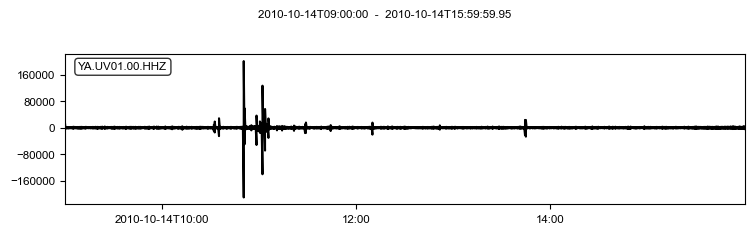

In [24]:
# Path to the example stream
filepath_waveforms = "../data/undervolc.mseed"

# Read example stream
stream = csn.read(filepath_waveforms)
stream.filter("highpass", freq=0.1)

# Show one trace
fig = stream[0].plot()

## Covariance matrix

The covariance matrix is calculated using the method `covseisnet.covariance.calculate_covariance_matrix`. The method returns the times, frequencies, and covariances of the covariance matrix. Among the parameters of the method, the window duration and the number of windows are important to consider. The window duration is the length of the Fourier estimation window in seconds, and the number of windows is the number of windows to average to estimate the covariance matrix. We can then visualize the covariance matrix at a given time and frequency, and its corresponding eigenvalues.

In [25]:
# No pre-processing
case_1 = "Original"
stream_1 = stream.copy()
whiten_1 = "none"

# Pre-process stream with temporal normalization
case_2 = "Temporal normalization"
stream_2 = stream.copy()
stream_2.time_normalize(method="smooth", smooth_length=901)
stream_2.taper(max_percentage=0.01)
whiten_2 = "none"

# Pre-process stream with whitening
case_3 = "Whitening on subwindows"
stream_3 = stream.copy()
whiten_3 = "window"

# Pre-process stream with slice whitening
case_4 = "Whitening on slice"
stream_4 = stream.copy()
whiten_4 = "slice"

# Pre-process stream with whitening and temporal normalization
case_5 = "Temporal normalization and whitening on slice"
stream_5 = stream.copy()
stream_5.time_normalize(method="smooth", smooth_length=1001)
stream_5.taper(max_percentage=0.01)
whiten_5 = "slice"

# Collect
cases = [case_1, case_2, case_3, case_4, case_5]
streams = [stream_1, stream_2, stream_3, stream_4, stream_5]
whitens = [whiten_1, whiten_2, whiten_3, whiten_4, whiten_5]

# Process cases
coherences = []
for stream, case, whiten in zip(streams, cases, whitens):

    # Calculate covariance matrix
    times, frequencies, covariances = csn.calculate_covariance_matrix(
        stream, window_duration=20, average=20, whiten=whiten
    )

    # Calculate coherence
    coherences.append(covariances.coherence())

## Compare the coherence for different cases

We can now plot the coherence for each case, with an example trace at the top.
The colorbars are fixed to better compare the coherences, and in particular,
the contrast within each case.



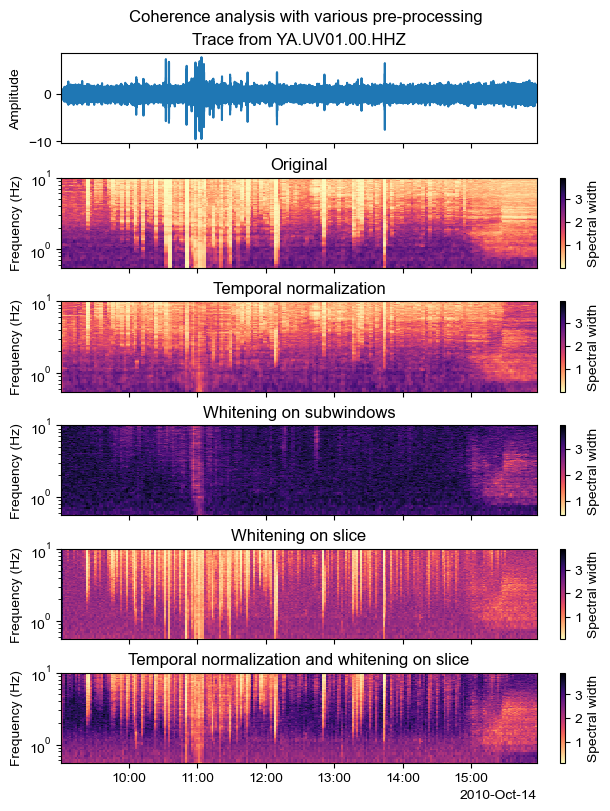

In [26]:
# Find global maximum
vmax = max([coherence.max() for coherence in coherences])

# Show
fig, ax = plt.subplots(
    nrows=len(cases) + 1,
    sharex=True,
    figsize=(6, 8),
    constrained_layout=True,
)

# Plot a trace
ax[0].plot(stream.times("matplotlib"), stream.traces[0].data)
ax[0].set_title(f"Trace from {stream.traces[0].id}")
ax[0].set_ylabel("Amplitude")

# Plot coherences
for i, (case, coherence) in enumerate(zip(cases, coherences)):
    csn.plot.coherence(
        times, frequencies, coherence, ax=ax[i + 1], vmax=vmax, f_min=0.5
    )
    ax[i + 1].set_title(case)
    ax[i + 1].set_ylabel("Frequency (Hz)")

# Set x-axis
csn.plot.dateticks(ax[-1])

# Figure title
fig.suptitle("Coherence analysis with various pre-processing");